Preprocessing of ILG Dataset (IntuiDoc loustic Database).
The ILG dataset is a collection of mono-stroke penbased gestures.
The goal of this file is to transform the online signal of each gesture to a 4D tensor:
- temporal (piece of motion, using a fixed length of curvilinear displacement ->$$thesholdCuDi$$ )
- X axis
- Y axis
- Stroke identification axis (Not used in ILG because it is monostroke)

The trajectory of the gesture will be cumuled at each frame of the temporal axis, e.g.
the last frame will contains the full gesture, the first frame will contains only the first
segment (of length $$thesholdCuDi$$). A black image is added at the end of the gesture.

In [1]:
import math
import os
import numpy as np
from typing import List, Tuple
from skimage.draw import line_aa, line
from skimage.transform import  resize
from scipy.ndimage.interpolation import shift
import matplotlib
from matplotlib import pyplot as plt
pathOutputPreprocess = "C:\\workspace2\\Datasets\\2D\\ILGDB\\PreprocessedData\\"
pathOutputImages = "C:\\workspace2\\Datasets\\2D\\ILGDB\\Images\\"
pathInputData = "C:\\workspace2\\Datasets\\2D\\ILGDB\\Data\\"
separator = "\\"
# pathOutputPreprocess = "/srv/tempdd/wmocaer/data/2D/ILGDB/PreprocessedData"
# pathOutputImages = "/srv/tempdd/wmocaer/data/2D/ILGDB/Images/"
# pathInputData = "/srv/tempdd/wmocaer/data/2D/ILGDB/Data/"
# separator = "/"
actionFileName = "Actions.csv"
if not os.path.exists(pathOutputPreprocess):
    os.mkdir(pathOutputPreprocess)
    os.mkdir(pathOutputPreprocess+separator+"Train")
    os.mkdir(pathOutputPreprocess+separator+"Test")

Read config file

In [2]:
f = open("config.txt")
configParams = f.readlines()
f.close()
configParams = eval("\n".join(configParams))

multiplierCoord = configParams["multiplierCoord"] #all the coordinates will be multiplied by this value
thresholdCuDi = configParams["thresholdCuDi"]*(multiplierCoord) # value in pixel
dimensionsOutputImage = np.array(configParams["dimensionsOutputImage"]) # x and y dimension of output

## Read data from files

In [3]:

def readFileAndAddData(file:str, gestures: List[Tuple[List[Tuple[float,float,float]],str]],multiplierCoord):
    """
    add the gestures of the 'file' in the 'gestures' list
    :param file: the file (.pts) which contains gestures
    :param gestures: the list to fill with gestures
    :return: void
    """
    f = open(file)
    lines = f.readlines()
    f.close()
    currentList: List[Tuple[float,float,float]] = [] #x,y,pression, pression is not used here
    currentClasse = ""
    previousCount = 0
    for id,line in enumerate(lines):
        if line[0] == "#" or line.strip() == "":
            if id==len(lines)-1:
                gestures.append((currentList, currentClasse))
                continue

            if (line.strip()==""):#ignore blank line
                continue
            if (currentClasse != ""):# not for the first
                assert len(currentList)==previousCount
                gestures.append((currentList, currentClasse))

            currentClasse, previousCount = line[1:].split()
            previousCount = (int) (previousCount)
            currentList = []
        else:
            splitted: List[str] = line.split()
            assert len(splitted)==3
            currentList.append((float(splitted[0])*multiplierCoord,
                                float(splitted[1])*multiplierCoord,
                                float(splitted[2])))
            if id==len(lines)-1:
                gestures.append((currentList, currentClasse))

gesturesTrain : List[Tuple[List[Tuple[float,float,float]],str]] = []
gesturesTest : List[Tuple[List[Tuple[float,float,float]],str]] = []

listFilesTest = os.listdir(pathInputData+"Test")
listFilesTrain = os.listdir(pathInputData+"Train")
print("Testing set")
for fileSample in listFilesTest:
    readFileAndAddData(pathInputData+"Test"+separator+fileSample,gesturesTest,multiplierCoord-0.1)
print("Training set")
for fileSample in listFilesTrain:
    readFileAndAddData(pathInputData+"Train"+separator+fileSample,gesturesTrain,multiplierCoord)
    readFileAndAddData(pathInputData+"Train"+separator+fileSample,gesturesTrain,multiplierCoord+0.1) # data augmentation
    readFileAndAddData(pathInputData+"Train"+separator+fileSample,gesturesTrain,multiplierCoord-0.1) # data augmentation
    readFileAndAddData(pathInputData+"Train"+separator+fileSample,gesturesTrain,multiplierCoord+0.2) # data augmentation
    readFileAndAddData(pathInputData+"Train"+separator+fileSample,gesturesTrain,multiplierCoord+0.3) # data augmentation

Testing set
Training set


## Put each gesture in little pieces of fixed length

In [4]:
def segmentGestureInPiecesOfMovement(gesture:List[Tuple[float,float,float]],thresholdCuDi) -> List[List[np.ndarray]]:
    currentCuDi = 0
    currentIndexGesture = 0

    previousPoint = np.array(gesture[0][0:2])
    pieces : List[List[np.ndarray]] = []
    currentListOfPoint:List[np.ndarray] = [previousPoint]
    while currentIndexGesture<len(gesture)-1:
        currentIndexGesture+=1
        coord = np.array(gesture[currentIndexGesture])[0:2]
        normDiff = np.linalg.norm(coord-previousPoint)
        if abs(currentCuDi+normDiff-thresholdCuDi)<0.00001: # threshold reached almost perfectly
            currentListOfPoint.append(coord)
            currentCuDi = 0
            pieces.append(currentListOfPoint)
            currentListOfPoint = [coord]
            previousPoint = coord
        elif currentCuDi+normDiff<thresholdCuDi: # threshold not reached yet
            currentListOfPoint.append(coord)
            currentCuDi += normDiff
            previousPoint = coord
        else: # over the threshold, in this case we interpolate linearly the 'perfect' point to reach the threshold
            missValue = thresholdCuDi-currentCuDi
            vectorPerfectLength = (coord-previousPoint)/normDiff*missValue
            intermediatePoint = previousPoint+vectorPerfectLength

            currentListOfPoint.append(intermediatePoint)
            currentCuDi = 0
            pieces.append(currentListOfPoint)
            currentListOfPoint = [intermediatePoint]
            previousPoint = intermediatePoint
            currentIndexGesture -= 1 # to do the loop on the same 'coord' point which is not yet reached

    # if there is some point at the end where the segments sum doesn't reach the threshold
    # we add them as another piece
    if len(currentListOfPoint) > 1:
        pieces.append(currentListOfPoint)
    return pieces
gesturesSegmentsTest: List[Tuple[List[List[np.ndarray]],str]] = []
gesturesSegmentsTrain: List[Tuple[List[List[np.ndarray]],str]] = []
print("Testing set...",)
for gesture in gesturesTest:
    gestureSegments: Tuple[List[List[np.ndarray]],str] = (segmentGestureInPiecesOfMovement(gesture[0],thresholdCuDi), gesture[1])
    gesturesSegmentsTest.append(gestureSegments)
print("Done,",len(gesturesTest),"elements")
print("Training set...")
for gesture in gesturesTrain:
    gestureSegments: Tuple[List[List[np.ndarray]],str] = (segmentGestureInPiecesOfMovement(gesture[0],thresholdCuDi), gesture[1])
    gesturesSegmentsTrain.append(gestureSegments)
print("Done",len(gesturesTrain),"elements")

Testing set...
Done, 1230 elements
Training set...
Done 3465 elements


### Exploration of the number of segments

(array([ 442, 1032,  893,  583,  312,  128,   50,   15,    6,    4],
      dtype=int64), array([ 3.,  8., 13., 18., 23., 28., 33., 38., 43., 48., 53.]))


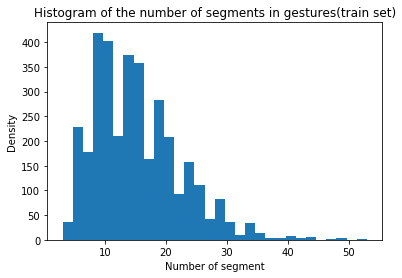

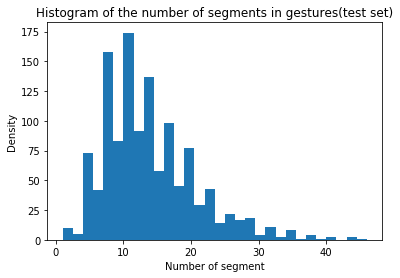

In [5]:
count = [len(gesture[0]) for gesture in gesturesSegmentsTrain]
print(np.histogram(count))
fig, ax = plt.subplots()

_, _, _ = ax.hist(count, 30,)

ax.set_xlabel('Number of segment')
ax.set_ylabel('Density')
ax.set_title('Histogram of the number of segments in gestures(train set)')
count = [len(gesture[0]) for gesture in gesturesSegmentsTest]
plt.savefig("AfterDataAugmentationTrain.png")
fig, ax = plt.subplots()

_, _, _ = ax.hist(count, 30)

ax.set_xlabel('Number of segment')
ax.set_ylabel('Density')
ax.set_title('Histogram of the number of segments in gestures(test set)')
plt.savefig("AfterDataAugmentationTest.png")

## Pixelisation of the gestures along the time

In [6]:
def pixelisationOfThePiecesOfGestures(gestureSegments: List[List[np.ndarray]]):
    center = dimensionsOutputImage/2.
    gest1 = gestureSegments[0][0][0],gestureSegments[0][0][1]
    offSet = center-gest1
    gest1 = gest1+offSet
    minX = gest1[0]
    minY = gest1[1]
    maxX = gest1[0]
    maxY = gest1[1]
    imagesAlongTime:List[np.ndarray[dimensionsOutputImage]] = [] # len(imagesAlongTime)==len(gestureSegments)
    image = np.zeros(shape=dimensionsOutputImage,dtype="bool")
    for segment in gestureSegments:
        for idPoint1 in range(0,len(segment)-1):
            shifted=False
            idPoint2 = idPoint1+1
            coordP1 = segment[idPoint1][0:2]+offSet
            coordP2 = segment[idPoint2][0:2]+offSet
            if coordP2[0]>dimensionsOutputImage[0]-2: # if X > border
                #shift all the image to left
                toShift = math.ceil(coordP2[0]-(dimensionsOutputImage[0]-2))
                offSet = offSet-[toShift,0]
                minX-=toShift
                shifted = True
                toShift,axis = -toShift,0
            if coordP2[1]>dimensionsOutputImage[1]-2:# if Y is < 1
                toShift = (math.ceil(coordP2[1])-(dimensionsOutputImage[1]-2))
                minY-=toShift
                offSet = offSet-[0,toShift]
                shifted = True
                toShift,axis = -toShift,1
            # if <0
            if coordP2[0]<0+2:
                toShift = -math.floor(coordP2[0])+2
                # if maxX+toShift>dimensionsOutputImage[0]: #overflow case
                #     print( Exception("Overlflow on right"))
                maxX+=toShift
                offSet = offSet+[toShift,0]
                shifted,axis = True,0
            if coordP2[1]<0+2:
                toShift = -math.floor(coordP1[1])+2
                maxY+=toShift
                offSet = offSet+[0,toShift]
                shifted,axis = True,1
            minX = min(coordP2[0],minX)
            maxX = max(coordP2[0],maxX)
            minY = min(coordP2[1],minY)
            maxY = min(coordP2[1],maxY)
            rr,cc,_ = line_aa(int(round(coordP1[0])),int(round(coordP1[1])),int(round(coordP2[0])),int(round(coordP2[1])))
            if shifted:
                #we put black at the opposite of the image in order to do the roll correctly
                if axis==0:
                    if toShift > 0:
                        image[-toShift:]= np.zeros([toShift,dimensionsOutputImage[1]])
                    else:
                        image[:-toShift]= np.zeros([-toShift,dimensionsOutputImage[1]])
                else:
                    if toShift > 0:
                        image[:,-toShift:]= np.zeros([dimensionsOutputImage[1],toShift])
                    else:
                        image[:,:-toShift]= np.zeros([dimensionsOutputImage[1],-toShift])
                #draw segments
                image[[r%(dimensionsOutputImage[0]) for r in rr],[c%(dimensionsOutputImage[1]) for c in cc]] = 1 # draw the line in the image
                #roll image (shift)
                image = np.roll(image,toShift,axis=axis)
            else:
                image[rr,cc] = 1
        imagesAlongTime.append(np.copy(np.transpose(image)))
    image = np.zeros(shape=dimensionsOutputImage,dtype="bool") #add a black image at end
    imagesAlongTime.append(np.copy(np.transpose(image)))
    return imagesAlongTime

### One exemple

In [7]:
segments = gesturesSegmentsTest[16][0]
firstGesture = pixelisationOfThePiecesOfGestures(segments)


<Figure size 432x288 with 0 Axes>

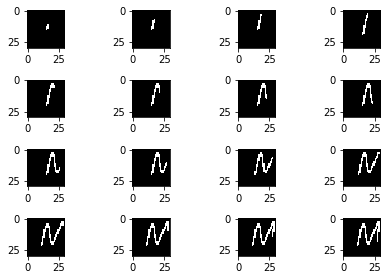

In [8]:
%matplotlib inline
plt.gray()
fig, axs = plt.subplots(4, 4)
fig.tight_layout()
tt = 0
for i in range(4):
    for j in range(4):
        try:
            axs[i, j].imshow(firstGesture[tt]*255, interpolation='nearest')
        except IndexError:
            pass
        tt+=1


### Create actions.csv which contains associations between name of class id

In [9]:
elemsTest = [gestureSegments[1] for gestureSegments in gesturesSegmentsTest]
elemsTrain = [gestureSegments[1] for gestureSegments in gesturesSegmentsTrain]
elemsTestSET = list(dict.fromkeys(elemsTest))
elemsTrainSET = list(dict.fromkeys(elemsTrain))
assert all(i in elemsTrainSET for i in elemsTestSET)
assert len(elemsTrainSET)==21
dictAssoc = {}
associations = ""
for id,gesture in enumerate(elemsTrainSET):
    associations+= str(id)+";"+gesture+"\n"
    dictAssoc[gesture]=id
f = open(pathOutputPreprocess+actionFileName,"w+")
f.write(associations)
f.close()

### Explore frequency by class

Text(0.5, 0, 'Classe')

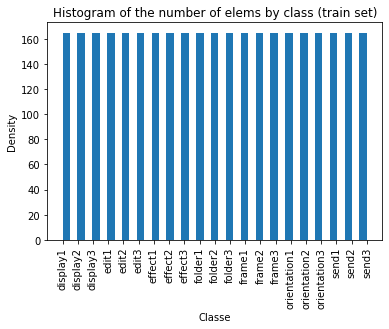

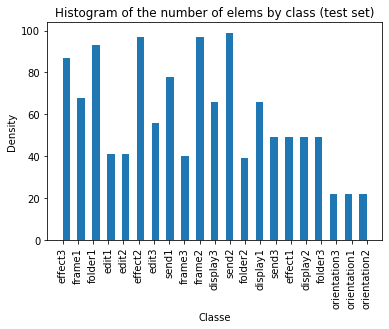

In [10]:
fig, ax = plt.subplots()
plt.xticks(rotation=90)

_, _, _ = ax.hist(elemsTrain, len(elemsTrainSET)*2-1)

ax.set_xlabel('Classe')
ax.set_ylabel('Density')
ax.set_title('Histogram of the number of elems by class (train set)')
count = [len(gesture[0]) for gesture in gesturesSegmentsTest]
fig, ax = plt.subplots()

_, _, _ = ax.hist(elemsTest, len(elemsTestSET)*2-1)

plt.xticks(rotation=90)
ax.set_ylabel('Density')
ax.set_title('Histogram of the number of elems by class (test set)')
ax.set_xlabel('Classe')

## Store the images in the preprocessed folder

In [11]:
saveImage = False
print("Testing set")
if saveImage:
    try:
        os.mkdir(pathOutputImages)
        os.mkdir(pathOutputImages+"Test")
        os.mkdir(pathOutputImages+"Train")
    except:
        pass

for i in range(len(gesturesSegmentsTest)):
    if(i%100==0):
        print(i,"on",len(gesturesSegmentsTest))
    images = pixelisationOfThePiecesOfGestures(gesturesSegmentsTest[i][0])
    img = np.expand_dims(images,axis=-1)
    name = str(i)+"_"+str(dictAssoc[gesturesSegmentsTest[i][1]])

    if saveImage:
        os.mkdir(pathOutputImages+"Test"+separator+name)
        for id,im in enumerate(images) :
            plt.imsave(pathOutputImages+"Test"+separator+name+separator+str(id)+".png",im)

    np.save(pathOutputPreprocess+"Test"+separator+name+".npy",img)

print("Done\nTraining set")
for i in range(len(gesturesSegmentsTrain)):
    if(i%100==0):
        print(i,"on",len(gesturesSegmentsTrain))
    images = pixelisationOfThePiecesOfGestures(gesturesSegmentsTrain[i][0])
    img = np.expand_dims(images,axis=-1)
    name = str(i)+"_"+str(dictAssoc[gesturesSegmentsTrain[i][1]])

    if saveImage:
        os.mkdir(pathOutputImages+"Train"+separator+name)
        for id,im in enumerate(images) :
            plt.imsave(pathOutputImages+"Train"+separator+name+separator+str(id)+".png",im)

    np.save(pathOutputPreprocess+"Train"+separator+name+".npy",img)

print("Done")


Testing set
0 on 1230
100 on 1230
200 on 1230
300 on 1230
400 on 1230
500 on 1230
600 on 1230
700 on 1230
800 on 1230
900 on 1230
1000 on 1230
1100 on 1230
1200 on 1230
Done
Training set
0 on 3465
100 on 3465
200 on 3465
300 on 3465
400 on 3465
500 on 3465
600 on 3465
700 on 3465
800 on 3465
900 on 3465
1000 on 3465
1100 on 3465
1200 on 3465
1300 on 3465
1400 on 3465
1500 on 3465
1600 on 3465
1700 on 3465
1800 on 3465
1900 on 3465
2000 on 3465
2100 on 3465
2200 on 3465
2300 on 3465
2400 on 3465
2500 on 3465
2600 on 3465
2700 on 3465
2800 on 3465
2900 on 3465
3000 on 3465
3100 on 3465
3200 on 3465
3300 on 3465
3400 on 3465
Done
